In [1]:
# ================================================================
# SECTION 0: IMPORTS AND SETUP
# ================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix, 
                             classification_report, accuracy_score, 
                             precision_score, recall_score, f1_score)
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully")


✓ All libraries imported successfully



SECTION 1: PROBLEM FORMULATION & TARGET VARIABLE ANALYSIS

Dataset Shape: (268114, 13)

First few rows:
   id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0   0       29367.99                 0.084           736      2528.42   
1   1       22108.02                 0.166           636      4593.10   
2   2       49566.20                 0.097           694     17005.15   
3   3       46858.25                 0.065           533      4682.48   
4   4       25496.70                 0.053           665     12184.43   

   interest_rate  gender marital_status education_level employment_status  \
0          13.67  Female         Single     High School     Self-employed   
1          12.92    Male        Married        Master's          Employed   
2           9.76    Male         Single     High School          Employed   
3          16.10  Female         Single     High School          Employed   
4          10.21    Male        Married     High School          Employ

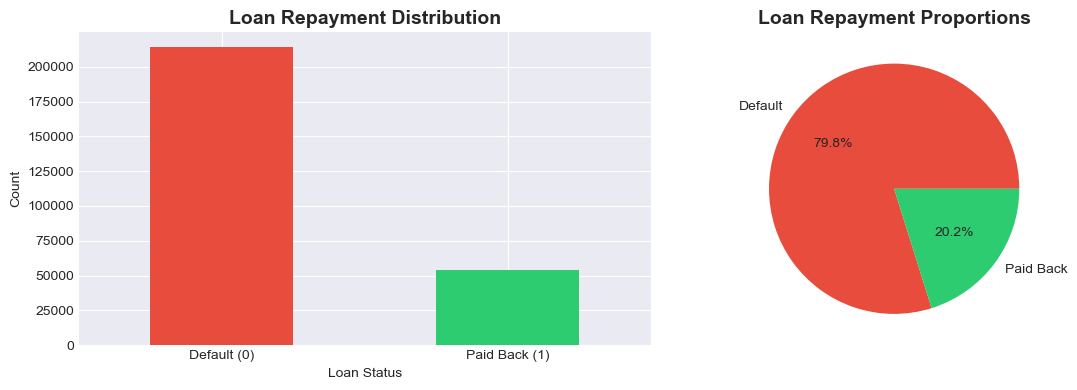


✓ Section 1 Complete: Target variable analyzed

SECTION 2: FEATURE ENGINEERING & PREPROCESSING PIPELINE

------------------------------------------------------------
2.1: EXPLORATORY DATA ANALYSIS
------------------------------------------------------------

Missing Values:
Series([], dtype: int64)
No missing values found!

Duplicate rows: 0

------------------------------------------------------------
FEATURE TYPE IDENTIFICATION
------------------------------------------------------------

Numerical Features (5):
  - annual_income
  - debt_to_income_ratio
  - credit_score
  - loan_amount
  - interest_rate

Categorical Features (6):
  - gender (3 unique values)
  - marital_status (4 unique values)
  - education_level (5 unique values)
  - employment_status (5 unique values)
  - loan_purpose (8 unique values)
  - grade_subgrade (30 unique values)

------------------------------------------------------------
CATEGORICAL FEATURE VALUES
----------------------------------------------------

In [2]:
# ================================================================
# SECTION 1: PROBLEM FORMULATION & TARGET VARIABLE ANALYSIS
# ================================================================

print("\n" + "="*60)
print("SECTION 1: PROBLEM FORMULATION & TARGET VARIABLE ANALYSIS")
print("="*60)

# Load the dataset
df = pd.read_csv('loan_data.csv')

print("\nDataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nBasic Statistics:")
print(df.describe())

# Target Variable Analysis
print("\n" + "-"*60)
print("TARGET VARIABLE ANALYSIS")
print("-"*60)

print("\nTarget Variable: 'loan_paid_back'")
print("- Value 1: Loan was paid back in full (NO DEFAULT)")
print("- Value 0: Loan was NOT paid back (DEFAULT)")

print("\nTarget Distribution:")
print(df['loan_paid_back'].value_counts())
print("\nTarget Proportions:")
print(df['loan_paid_back'].value_counts(normalize=True))

# Calculate class imbalance
default_rate = (df['loan_paid_back'] == 0).sum() / len(df)
print(f"\nDefault Rate: {default_rate:.2%}")
print(f"Non-Default Rate: {(1-default_rate):.2%}")

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
df['loan_paid_back'].value_counts().plot(kind='bar', ax=axes[0], color=['#e74c3c', '#2ecc71'])
axes[0].set_title('Loan Repayment Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Loan Status')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Default (0)', 'Paid Back (1)'], rotation=0)

# Pie chart
df['loan_paid_back'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%',
                                          colors=['#e74c3c', '#2ecc71'],
                                          labels=['Default', 'Paid Back'])
axes[1].set_ylabel('')
axes[1].set_title('Loan Repayment Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Section 1 Complete: Target variable analyzed")

# ================================================================
# SECTION 2: FEATURE ENGINEERING & PREPROCESSING PIPELINE
# ================================================================

print("\n" + "="*60)
print("SECTION 2: FEATURE ENGINEERING & PREPROCESSING PIPELINE")
print("="*60)

# 2.1: Exploratory Data Analysis
print("\n" + "-"*60)
print("2.1: EXPLORATORY DATA ANALYSIS")
print("-"*60)

# Check for missing values
print("\nMissing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

if missing_values.sum() == 0:
    print("No missing values found!")
else:
    print(f"\nTotal missing values: {missing_values.sum()}")

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# Identify feature types
print("\n" + "-"*60)
print("FEATURE TYPE IDENTIFICATION")
print("-"*60)

# Get all columns except id and target
all_columns = df.columns.tolist()
all_columns.remove('id')
all_columns.remove('loan_paid_back')

# Identify numerical and categorical features
numerical_features = df[all_columns].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df[all_columns].select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical Features ({len(numerical_features)}):")
for feat in numerical_features:
    print(f"  - {feat}")

print(f"\nCategorical Features ({len(categorical_features)}):")
for feat in categorical_features:
    unique_count = df[feat].nunique()
    print(f"  - {feat} ({unique_count} unique values)")

# Display unique values for categorical features
print("\n" + "-"*60)
print("CATEGORICAL FEATURE VALUES")
print("-"*60)

for col in categorical_features:
    print(f"\n{col}:")
    print(df[col].value_counts())

# 2.2: Feature Engineering
print("\n" + "-"*60)
print("2.2: FEATURE ENGINEERING")
print("-"*60)

# Create a copy for feature engineering
df_fe = df.copy()

# Create new features
print("\nCreating new features...")

# 1. Income to Loan Ratio
df_fe['income_to_loan_ratio'] = df_fe['annual_income'] / (df_fe['loan_amount'] + 1)
print("✓ Created: income_to_loan_ratio")

# 2. Credit Risk Score (interaction between debt ratio and credit score)
df_fe['credit_risk_score'] = df_fe['debt_to_income_ratio'] * (850 - df_fe['credit_score'])
print("✓ Created: credit_risk_score")

# 3. High Interest Flag
df_fe['high_interest_flag'] = (df_fe['interest_rate'] > df_fe['interest_rate'].median()).astype(int)
print("✓ Created: high_interest_flag")

# 4. Debt Payment Burden
df_fe['debt_payment_burden'] = df_fe['debt_to_income_ratio'] * df_fe['interest_rate']
print("✓ Created: debt_payment_burden")

# Update numerical features list
numerical_features_new = numerical_features + ['income_to_loan_ratio', 'credit_risk_score', 
                                               'high_interest_flag', 'debt_payment_burden']

print(f"\nTotal features after engineering: {len(numerical_features_new) + len(categorical_features)}")

# 2.3: Train-Test Split
print("\n" + "-"*60)
print("2.3: TRAIN-TEST SPLIT")
print("-"*60)

# Separate features and target
X = df_fe.drop(['id', 'loan_paid_back'], axis=1)
y = df_fe['loan_paid_back']

# Split data (80-20 with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]} ({X_train.shape[0]/len(df):.1%})")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(df):.1%})")
print(f"\nTraining set default rate: {(y_train==0).sum()/len(y_train):.2%}")
print(f"Test set default rate: {(y_test==0).sum()/len(y_test):.2%}")

# Store test IDs for later
test_ids = df_fe.loc[X_test.index, 'id'].values

# 2.4: Handle Missing Values
print("\n" + "-"*60)
print("2.4: MISSING VALUE IMPUTATION")
print("-"*60)

# Check for missing values in train/test
train_missing = X_train.isnull().sum()
test_missing = X_test.isnull().sum()

if train_missing.sum() > 0 or test_missing.sum() > 0:
    print("\nImputing missing values...")
    
    # Numerical imputation
    num_imputer = SimpleImputer(strategy='median')
    X_train[numerical_features_new] = num_imputer.fit_transform(X_train[numerical_features_new])
    X_test[numerical_features_new] = num_imputer.transform(X_test[numerical_features_new])
    
    # Categorical imputation
    cat_imputer = SimpleImputer(strategy='most_frequent')
    X_train[categorical_features] = cat_imputer.fit_transform(X_train[categorical_features])
    X_test[categorical_features] = cat_imputer.transform(X_test[categorical_features])
    
    print("✓ Missing values imputed")
else:
    print("\nNo missing values to impute!")

# 2.5: Encode Categorical Features
print("\n" + "-"*60)
print("2.5: CATEGORICAL FEATURE ENCODING")
print("-"*60)

# Create copies to avoid warnings
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

# Label encoding for categorical features
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    # Fit on training data
    X_train_encoded[col] = le.fit_transform(X_train_encoded[col].astype(str))
    # Transform test data, handling unseen categories
    X_test_encoded[col] = X_test_encoded[col].astype(str).map(
        lambda x: le.transform([x])[0] if x in le.classes_ else -1
    )
    label_encoders[col] = le
    print(f"✓ Encoded: {col} ({len(le.classes_)} categories)")

# 2.6: Feature Scaling
print("\n" + "-"*60)
print("2.6: FEATURE SCALING")
print("-"*60)

# Scale numerical features
scaler = StandardScaler()
X_train_encoded[numerical_features_new] = scaler.fit_transform(X_train_encoded[numerical_features_new])
X_test_encoded[numerical_features_new] = scaler.transform(X_test_encoded[numerical_features_new])

print("✓ Numerical features scaled using StandardScaler")
print(f"\nFinal feature count: {X_train_encoded.shape[1]}")

print("\n✓ Section 2 Complete: Data preprocessed and ready for modeling")



SECTION 3: MODEL DEVELOPMENT AND TUNING

------------------------------------------------------------
3.1: TRAINING MULTIPLE MODELS
------------------------------------------------------------

Class imbalance ratio (for XGBoost): 0.25

Training Logistic Regression...
  Train AUC: 0.8896
  Test AUC:  0.8930

Training Random Forest...
  Train AUC: 0.9196
  Test AUC:  0.9127

Training XGBoost...
  Train AUC: 0.9331
  Test AUC:  0.9194

------------------------------------------------------------
3.2: MODEL SELECTION
------------------------------------------------------------

Model Comparison:
              Model  Train AUC  Test AUC  Overfitting
            XGBoost   0.933085  0.919427     0.013658
      Random Forest   0.919607  0.912669     0.006938
Logistic Regression   0.889578  0.893036    -0.003458

✓ Best Model Selected: XGBoost
  Test AUC: 0.9194

------------------------------------------------------------
3.3: CROSS-VALIDATION
------------------------------------------------

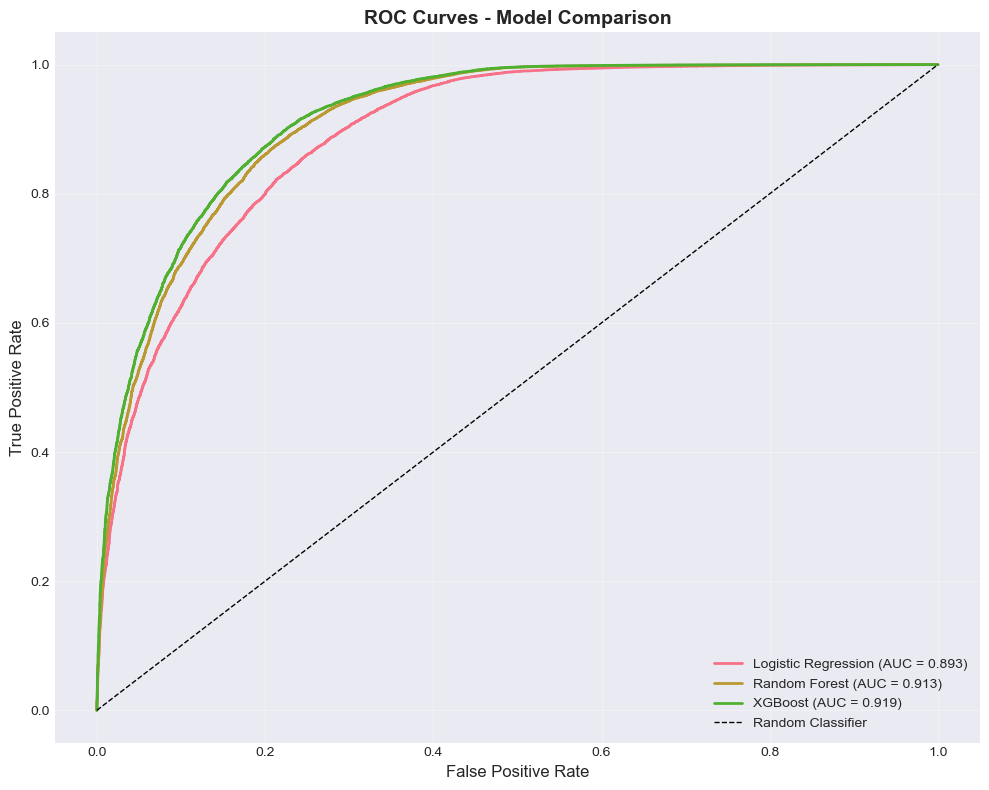

✓ ROC curve plotted

------------------------------------------------------------
3.5: OPTIMAL THRESHOLD SELECTION
------------------------------------------------------------

Optimal Threshold (Youden's Index): 0.4733
  TPR at threshold: 0.9024
  FPR at threshold: 0.2269

------------------------------------------------------------
3.6: DETAILED PERFORMANCE METRICS
------------------------------------------------------------

Using threshold: 0.4733

Test Set Metrics:
  Accuracy:  0.8764
  Precision: 0.9403
  Recall:    0.9024
  F1-Score:  0.9210
  AUC-ROC:   0.9194

Classification Report:
              precision    recall  f1-score   support

     Default       0.67      0.77      0.72     10809
   Paid Back       0.94      0.90      0.92     42814

    accuracy                           0.88     53623
   macro avg       0.80      0.84      0.82     53623
weighted avg       0.89      0.88      0.88     53623



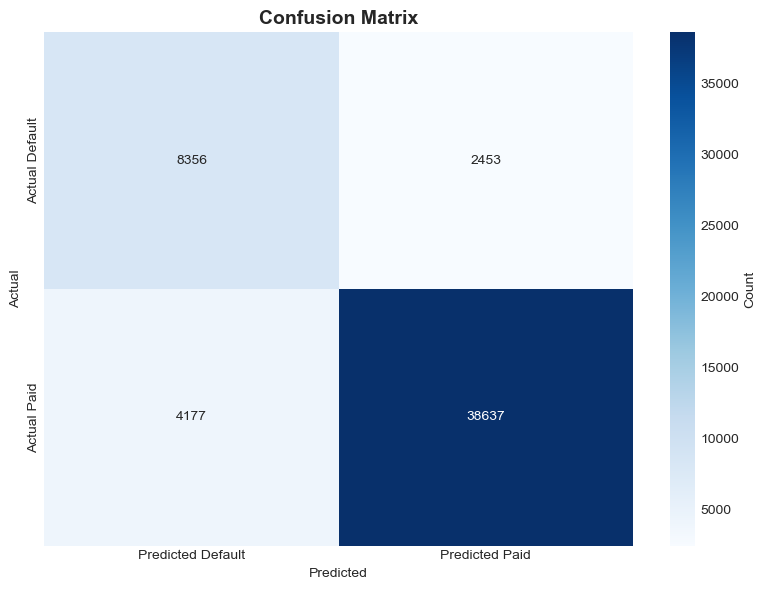


✓ Section 3 Complete: Model trained and evaluated


In [3]:
# ================================================================
# SECTION 3: MODEL DEVELOPMENT AND TUNING
# ================================================================

print("\n" + "="*60)
print("SECTION 3: MODEL DEVELOPMENT AND TUNING")
print("="*60)

# 3.1: Baseline Models
print("\n" + "-"*60)
print("3.1: TRAINING MULTIPLE MODELS")
print("-"*60)

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\nClass imbalance ratio (for XGBoost): {scale_pos_weight:.2f}")

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        class_weight='balanced'
    ),
    'XGBoost': XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='auc'
    )
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train_encoded, y_train)
    
    # Predict probabilities
    y_train_pred_proba = model.predict_proba(X_train_encoded)[:, 1]
    y_test_pred_proba = model.predict_proba(X_test_encoded)[:, 1]
    
    # Calculate AUC
    train_auc = roc_auc_score(y_train, y_train_pred_proba)
    test_auc = roc_auc_score(y_test, y_test_pred_proba)
    
    # Store results
    results[name] = {
        'model': model,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'y_pred_proba': y_test_pred_proba
    }
    
    print(f"  Train AUC: {train_auc:.4f}")
    print(f"  Test AUC:  {test_auc:.4f}")

# 3.2: Select Best Model
print("\n" + "-"*60)
print("3.2: MODEL SELECTION")
print("-"*60)

# Compare models
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train AUC': [results[m]['train_auc'] for m in results.keys()],
    'Test AUC': [results[m]['test_auc'] for m in results.keys()],
    'Overfitting': [results[m]['train_auc'] - results[m]['test_auc'] for m in results.keys()]
})
comparison_df = comparison_df.sort_values('Test AUC', ascending=False)

print("\nModel Comparison:")
print(comparison_df.to_string(index=False))

# Select best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
y_pred_proba = results[best_model_name]['y_pred_proba']

print(f"\n✓ Best Model Selected: {best_model_name}")
print(f"  Test AUC: {comparison_df.iloc[0]['Test AUC']:.4f}")

# 3.3: Cross-Validation
print("\n" + "-"*60)
print("3.3: CROSS-VALIDATION")
print("-"*60)

cv_scores = cross_val_score(
    best_model, X_train_encoded, y_train, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc'
)

print(f"\n5-Fold Cross-Validation AUC Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print(f"\nMean CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# 3.4: ROC Curve
print("\n" + "-"*60)
print("3.4: ROC CURVE ANALYSIS")
print("-"*60)

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

for name in results.keys():
    y_pred = results[name]['y_pred_proba']
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = results[name]['test_auc']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ ROC curve plotted")

# 3.5: Find Optimal Threshold
print("\n" + "-"*60)
print("3.5: OPTIMAL THRESHOLD SELECTION")
print("-"*60)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Method 1: Youden's Index (maximize TPR - FPR)
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]

print(f"\nOptimal Threshold (Youden's Index): {optimal_threshold:.4f}")
print(f"  TPR at threshold: {tpr[optimal_idx]:.4f}")
print(f"  FPR at threshold: {fpr[optimal_idx]:.4f}")

# Generate predictions with optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# 3.6: Model Performance Metrics
print("\n" + "-"*60)
print("3.6: DETAILED PERFORMANCE METRICS")
print("-"*60)

print(f"\nUsing threshold: {optimal_threshold:.4f}")
print(f"\nTest Set Metrics:")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_optimal):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_optimal):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_optimal):.4f}")
print(f"  F1-Score:  {f1_score(y_test, y_pred_optimal):.4f}")
print(f"  AUC-ROC:   {roc_auc_score(y_test, y_pred_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimal, 
                          target_names=['Default', 'Paid Back']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_optimal)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Default', 'Predicted Paid'],
            yticklabels=['Actual Default', 'Actual Paid'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Section 3 Complete: Model trained and evaluated")


SECTION 4: SUBGROUP ANALYSIS

------------------------------------------------------------
4.1: SUBGROUP ANALYSIS BY EDUCATION LEVEL
------------------------------------------------------------

AUC by Education Level:
Education Level  Sample Size Default Rate      AUC
          Other         2336       20.21% 0.929985
     Bachelor's        25263       21.23% 0.920480
    High School        16701       18.65% 0.917489
       Master's         8341       20.30% 0.916673
            PhD          982       16.90% 0.915456


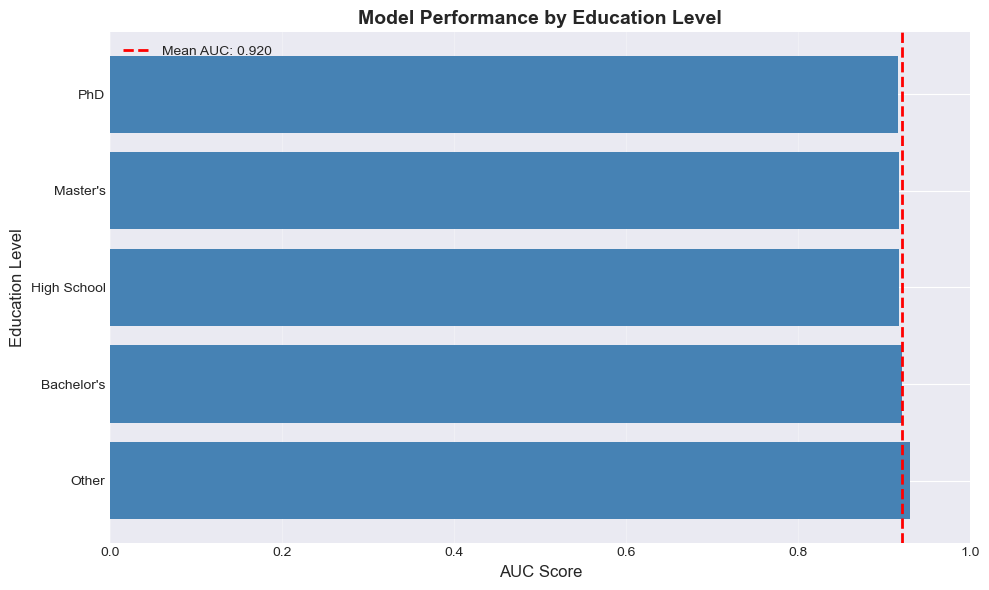


------------------------------------------------------------
4.2: SUBGROUP ANALYSIS BY LOAN PURPOSE
------------------------------------------------------------

Top 3 Performing Loan Purposes:
Loan Purpose  Sample Size Default Rate      AUC
   Education         3202       22.08% 0.931073
    Vacation          760       21.05% 0.928010
     Medical         2088       22.84% 0.924623

Bottom 3 Performing Loan Purposes:
      Loan Purpose  Sample Size Default Rate      AUC
             Other         5785       20.12% 0.918472
Debt consolidation        29317       20.38% 0.918399
               Car         5353       19.97% 0.911365

All Loan Purposes (sorted by AUC):
      Loan Purpose  Sample Size Default Rate      AUC
         Education         3202       22.08% 0.931073
          Vacation          760       21.05% 0.928010
           Medical         2088       22.84% 0.924623
              Home         4027       17.21% 0.922231
          Business         3091       18.28% 0.921637
 

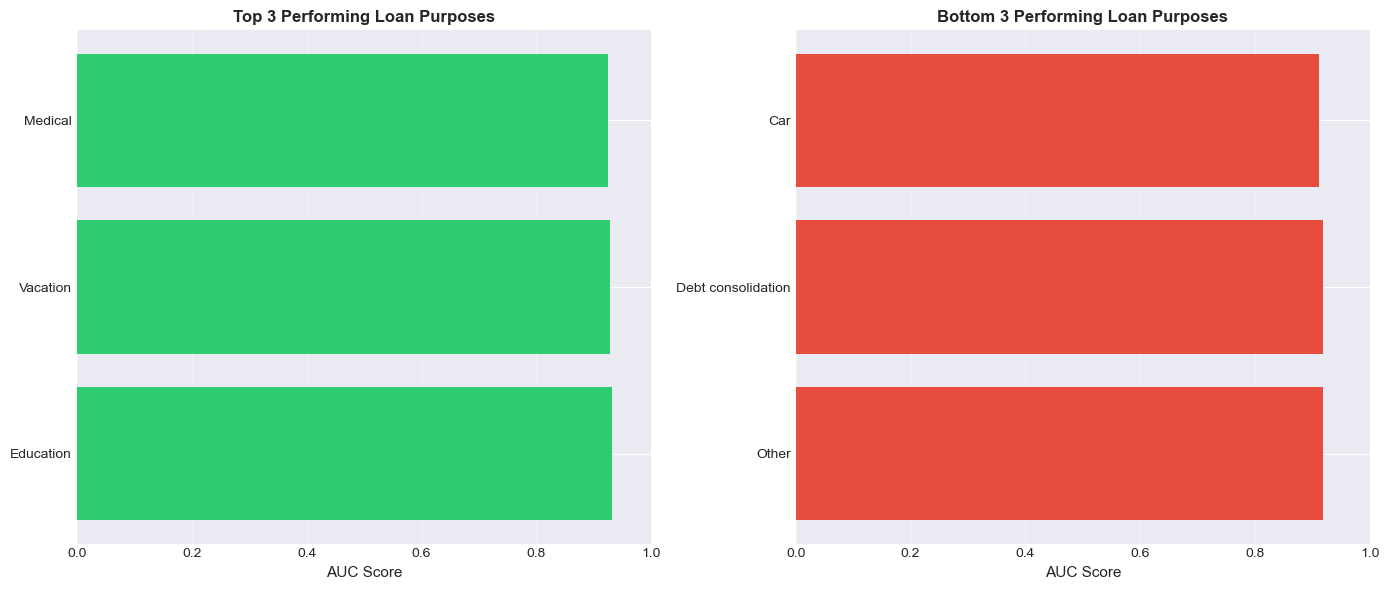


------------------------------------------------------------
4.3: FAIRNESS ASSESSMENT
------------------------------------------------------------

Education Level AUC Range: 0.0145
  Min AUC: 0.9155
  Max AUC: 0.9300
  Std Dev: 0.0059

Loan Purpose AUC Range: 0.0197
  Min AUC: 0.9114
  Max AUC: 0.9311
  Std Dev: 0.0061

✓ Model shows GOOD fairness across education levels (AUC range < 0.05)
✓ Model shows GOOD fairness across loan purposes (AUC range < 0.05)

✓ Section 4 Complete: Subgroup analysis finished


In [4]:
# ================================================================
# SECTION 4: SUBGROUP ANALYSIS
# ================================================================

print("\n" + "="*60)
print("SECTION 4: SUBGROUP ANALYSIS")
print("="*60)

# 4.1: Analysis by Education Level
print("\n" + "-"*60)
print("4.1: SUBGROUP ANALYSIS BY EDUCATION LEVEL")
print("-"*60)

# Get original education levels for test set
education_test = X_test['education_level'].values

# Calculate AUC for each education level
education_results = []

unique_education = sorted(X_test['education_level'].unique())

for edu_level in unique_education:
    mask = education_test == edu_level
    if mask.sum() > 0:
        try:
            auc = roc_auc_score(y_test[mask], y_pred_proba[mask])
            education_results.append({
                'Education Level': edu_level,
                'Sample Size': mask.sum(),
                'Default Rate': f"{(y_test[mask] == 0).sum() / mask.sum():.2%}",
                'AUC': auc
            })
        except:
            education_results.append({
                'Education Level': edu_level,
                'Sample Size': mask.sum(),
                'Default Rate': f"{(y_test[mask] == 0).sum() / mask.sum():.2%}",
                'AUC': np.nan
            })

education_df = pd.DataFrame(education_results)
education_df = education_df.sort_values('AUC', ascending=False)

print("\nAUC by Education Level:")
print(education_df.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
bars = plt.barh(education_df['Education Level'], education_df['AUC'], color='steelblue')
plt.xlabel('AUC Score', fontsize=12)
plt.ylabel('Education Level', fontsize=12)
plt.title('Model Performance by Education Level', fontsize=14, fontweight='bold')
plt.xlim(0, 1)
plt.axvline(x=education_df['AUC'].mean(), color='red', linestyle='--', 
            label=f'Mean AUC: {education_df["AUC"].mean():.3f}', linewidth=2)
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('auc_by_education.png', dpi=300, bbox_inches='tight')
plt.show()

# 4.2: Analysis by Loan Purpose
print("\n" + "-"*60)
print("4.2: SUBGROUP ANALYSIS BY LOAN PURPOSE")
print("-"*60)

# Get original loan purposes for test set
purpose_test = X_test['loan_purpose'].values

# Calculate AUC for each loan purpose
purpose_results = []

unique_purposes = X_test['loan_purpose'].unique()

for purpose in unique_purposes:
    mask = purpose_test == purpose
    if mask.sum() > 10:  # Only include if sufficient samples
        try:
            auc = roc_auc_score(y_test[mask], y_pred_proba[mask])
            purpose_results.append({
                'Loan Purpose': purpose,
                'Sample Size': mask.sum(),
                'Default Rate': f"{(y_test[mask] == 0).sum() / mask.sum():.2%}",
                'AUC': auc
            })
        except:
            purpose_results.append({
                'Loan Purpose': purpose,
                'Sample Size': mask.sum(),
                'Default Rate': f"{(y_test[mask] == 0).sum() / mask.sum():.2%}",
                'AUC': np.nan
            })

purpose_df = pd.DataFrame(purpose_results)
purpose_df = purpose_df.sort_values('AUC', ascending=False)

# Get top 3 and bottom 3
top_3 = purpose_df.head(3)
bottom_3 = purpose_df.tail(3)

print("\nTop 3 Performing Loan Purposes:")
print(top_3.to_string(index=False))

print("\nBottom 3 Performing Loan Purposes:")
print(bottom_3.to_string(index=False))

print("\nAll Loan Purposes (sorted by AUC):")
print(purpose_df.to_string(index=False))

# Visualize Top 3 and Bottom 3
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Top 3
axes[0].barh(top_3['Loan Purpose'], top_3['AUC'], color='#2ecc71')
axes[0].set_xlabel('AUC Score', fontsize=11)
axes[0].set_title('Top 3 Performing Loan Purposes', fontsize=12, fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].grid(axis='x', alpha=0.3)

# Bottom 3
axes[1].barh(bottom_3['Loan Purpose'], bottom_3['AUC'], color='#e74c3c')
axes[1].set_xlabel('AUC Score', fontsize=11)
axes[1].set_title('Bottom 3 Performing Loan Purposes', fontsize=12, fontweight='bold')
axes[1].set_xlim(0, 1)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('auc_by_loan_purpose.png', dpi=300, bbox_inches='tight')
plt.show()

# 4.3: Fairness Assessment
print("\n" + "-"*60)
print("4.3: FAIRNESS ASSESSMENT")
print("-"*60)

# Calculate AUC range
edu_auc_range = education_df['AUC'].max() - education_df['AUC'].min()
purpose_auc_range = purpose_df['AUC'].max() - purpose_df['AUC'].min()

print(f"\nEducation Level AUC Range: {edu_auc_range:.4f}")
print(f"  Min AUC: {education_df['AUC'].min():.4f}")
print(f"  Max AUC: {education_df['AUC'].max():.4f}")
print(f"  Std Dev: {education_df['AUC'].std():.4f}")

print(f"\nLoan Purpose AUC Range: {purpose_auc_range:.4f}")
print(f"  Min AUC: {purpose_df['AUC'].min():.4f}")
print(f"  Max AUC: {purpose_df['AUC'].max():.4f}")
print(f"  Std Dev: {purpose_df['AUC'].std():.4f}")

# Fairness interpretation
if edu_auc_range < 0.05:
    print("\n✓ Model shows GOOD fairness across education levels (AUC range < 0.05)")
elif edu_auc_range < 0.10:
    print("\n⚠ Model shows MODERATE fairness across education levels (AUC range < 0.10)")
else:
    print("\n✗ Model shows POOR fairness across education levels (AUC range >= 0.10)")

if purpose_auc_range < 0.05:
    print("✓ Model shows GOOD fairness across loan purposes (AUC range < 0.05)")
elif purpose_auc_range < 0.10:
    print("⚠ Model shows MODERATE fairness across loan purposes (AUC range < 0.10)")
else:
    print("✗ Model shows POOR fairness across loan purposes (AUC range >= 0.10)")

print("\n✓ Section 4 Complete: Subgroup analysis finished")


SECTION 5: SAVE PREDICTIONS

✓ Predictions saved to 'loan_predictions.csv'

First 10 predictions:
       id  loan_paid_back_probability  predicted_loan_paid_back  \
0    2856                    0.755227                         1   
1  196063                    0.817097                         1   
2   26708                    0.703685                         1   
3  108686                    0.653883                         1   
4   20166                    0.890852                         1   
5  170247                    0.866538                         1   
6  179554                    0.770988                         1   
7  185743                    0.312525                         0   
8   32494                    0.812015                         1   
9  224418                    0.764576                         1   

   actual_loan_paid_back  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
5

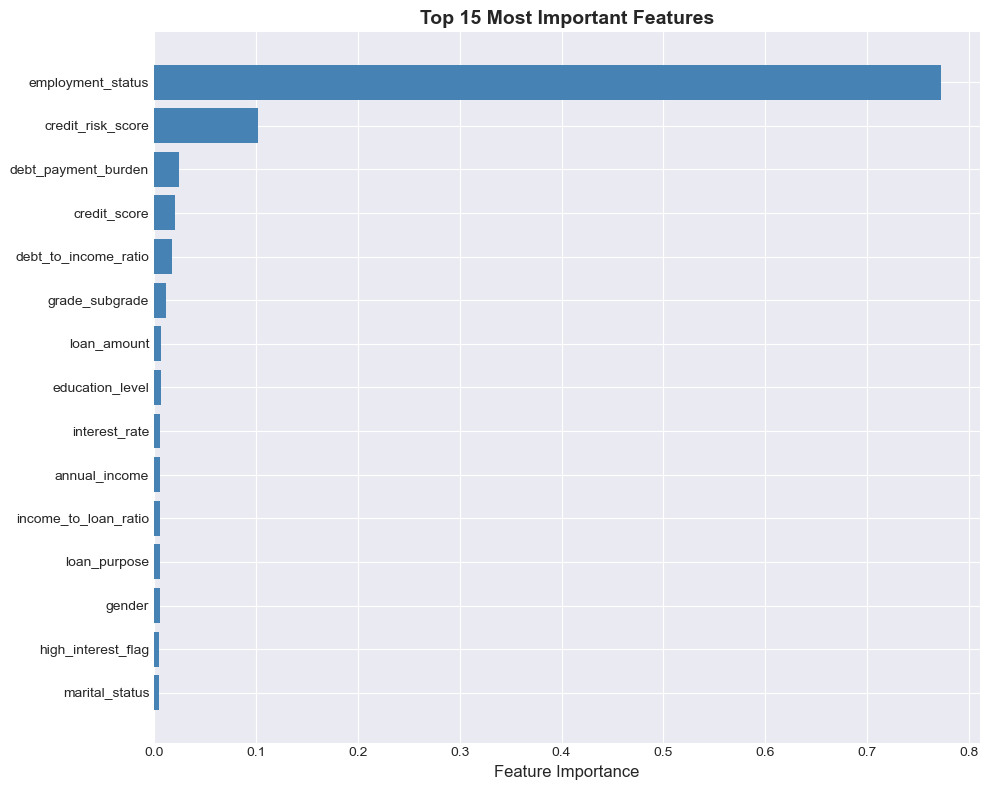


✓ Feature importance analysis complete

FINAL SUMMARY REPORT

---------------------MODEL PERFORMANCE----------------------
Best Model: XGBoost
Test AUC: 0.9194
Accuracy: 0.8764
Precision: 0.9403
Recall: 0.9024
F1-Score: 0.9210

----------------------FAIRNESS METRICS----------------------
Education Level AUC Range: 0.0145
Loan Purpose AUC Range: 0.0197

------------------------OUTPUT FILES------------------------
✓ loan_predictions.csv - Model predictions
✓ target_distribution.png - Target variable analysis
✓ roc_curves.png - ROC curve comparison
✓ confusion_matrix.png - Confusion matrix
✓ auc_by_education.png - Performance by education
✓ auc_by_loan_purpose.png - Performance by loan purpose
✓ feature_importance.png - Feature importance plot

ANALYSIS COMPLETE!


In [5]:
#Optional
# ================================================================
# SECTION 5: SAVE PREDICTIONS
# ================================================================

print("\n" + "="*60)
print("SECTION 5: SAVE PREDICTIONS")
print("="*60)

# Create predictions dataframe
predictions_df = pd.DataFrame({
    'id': test_ids,
    'loan_paid_back_probability': y_pred_proba,
    'predicted_loan_paid_back': y_pred_optimal,
    'actual_loan_paid_back': y_test.values
})

# Save to CSV
predictions_df.to_csv('loan_predictions.csv', index=False)
print("\n✓ Predictions saved to 'loan_predictions.csv'")

print(f"\nFirst 10 predictions:")
print(predictions_df.head(10))

# ================================================================
# SECTION 6: FEATURE IMPORTANCE
# ================================================================

print("\n" + "="*60)
print("SECTION 6: FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature importance (if available)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X_train_encoded.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Feature Importance', fontsize=12)
    plt.title('Top 15 Most Important Features', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Feature importance analysis complete")

# ================================================================
# SECTION 7: SUMMARY REPORT
# ================================================================

print("\n" + "="*60)
print("FINAL SUMMARY REPORT")
print("="*60)

print(f"\n{'MODEL PERFORMANCE':-^60}")
print(f"Best Model: {best_model_name}")
print(f"Test AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_optimal):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_optimal):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_optimal):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_optimal):.4f}")

print(f"\n{'FAIRNESS METRICS':-^60}")
print(f"Education Level AUC Range: {edu_auc_range:.4f}")
print(f"Loan Purpose AUC Range: {purpose_auc_range:.4f}")

print(f"\n{'OUTPUT FILES':-^60}")
print("✓ loan_predictions.csv - Model predictions")
print("✓ target_distribution.png - Target variable analysis")
print("✓ roc_curves.png - ROC curve comparison")
print("✓ confusion_matrix.png - Confusion matrix")
print("✓ auc_by_education.png - Performance by education")
print("✓ auc_by_loan_purpose.png - Performance by loan purpose")
print("✓ feature_importance.png - Feature importance plot")

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)